In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Parameters

In [ ]:
GAMMA = 1.4 

## Solution algorithm

In [3]:
def theta_from_beta(beta, M, gamma=1.4):
    """
	Returns theta (rad) for an oblique shock.
	Accepts beta as scalar or numpy array.
    """
    beta = np.asarray(beta)                     # sûreté : cast en ndarray
    term1 = 2.0 / np.tan(beta)
    term2 = M**2 * np.sin(beta)**2 - 1.0
    term3 = M**2 * (gamma + np.cos(2.0 * beta)) + 2.0
    return np.arctan(term1 * term2 / term3)     # np.arctan !

In [4]:
def bisection(beta_low, beta_high, f, tol=1e-10, max_iter=100):
	"""Find root of f(β)=0 using bisection method (β in rad)."""
	f_low = f(beta_low)
	for _ in range(max_iter):
		beta_mid = 0.5 * (beta_low + beta_high)
		f_mid = f(beta_mid)
		if abs(f_mid) < tol:
			return beta_mid
		if f_low * f_mid < 0.0:
			beta_high = beta_mid
		else:
			beta_low, f_low = beta_mid, f_mid
	raise RuntimeError("Bisection did not converge.")

In [5]:
def bracket_roots(theta_rad, M, gamma=GAMMA, n_scan=4000):
	"""
	Scan β from Mach line to 89.9°:
	returns list of intervals [β_low, β_high] where f changes sign.
	"""
	beta_min = math.asin(1.0 / M) + 1e-6
	beta_max = math.radians(89.9)

	betas = np.linspace(beta_min, beta_max, n_scan)
	f_vals = theta_from_beta(betas, M, gamma) - theta_rad

	idx = np.where(np.diff(np.sign(f_vals)))[0]      # indices where sign changes
	return [(betas[i], betas[i + 1]) for i in idx]   # one interval → one root

In [6]:
def beta_solutions(theta_deg, M, gamma=GAMMA):
    """
    Returns a list [β_weak (rad), β_strong (rad) (optional)]
    for a given (θ, M) pair. 0 or 1 or 2 solutions.
    """
    theta_rad = math.radians(theta_deg)
    intervals = bracket_roots(theta_rad, M, gamma)
    betas = []
    for beta_low, beta_high in intervals:
        betas.append(
            bisection(beta_low, beta_high,
                      lambda b: theta_from_beta(b, M, gamma) - theta_rad))
    return betas

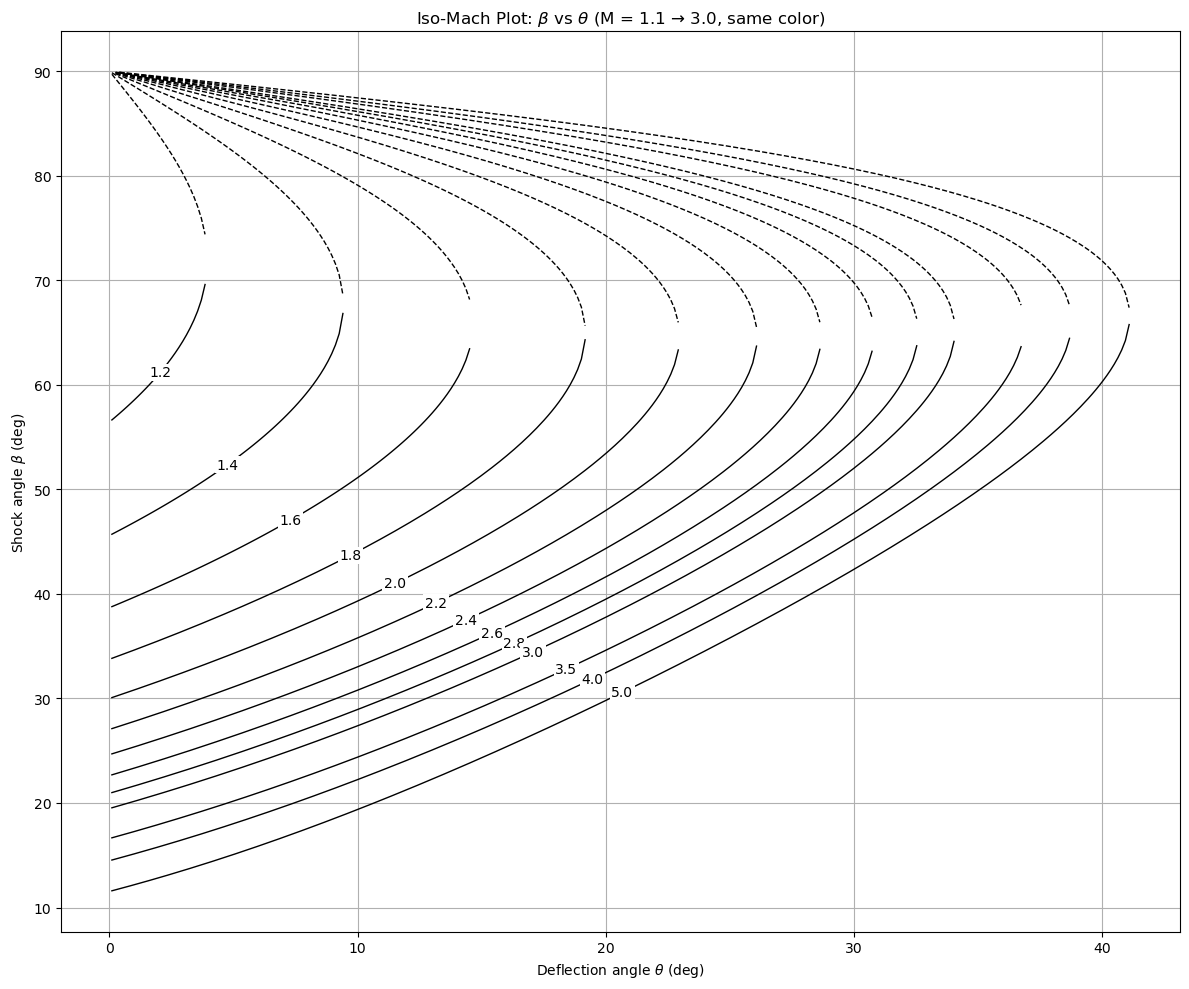

In [8]:
theta_vals = np.linspace(0.1, 45.0, 300)            # θ in degrees
mach_dense  = np.round(np.arange(1.2, 3.0, 0.2), 1) # 1.2, 1.4, …, 2.8
mach_extra  = [3.0, 3.5, 4.0, 5.0]
mach_list   = np.concatenate((mach_dense, mach_extra))

plt.figure(figsize=(12, 10))

for M in mach_list:
	weak_pts, strong_pts = [], []

	for theta in theta_vals:
		betas = beta_solutions(theta, M)            # in radians
		if not betas:
			break                                   # θ exceeds θ_max → stop

		# weak β = first root
		weak_pts.append((theta, math.degrees(betas[0])))

		# strong β = second root if it exists
		if len(betas) > 1:
			strong_pts.append((theta, math.degrees(betas[1])))

	# --- plot accumulated points --------------------------
	if weak_pts:
		t_w, b_w = zip(*weak_pts)
		plt.plot(t_w, b_w, color='black', lw=1)

		# Mach label on weak branch (middle of curve)
		mid = len(t_w) // 2
		plt.text(t_w[mid], b_w[mid], f"{M}",
				 ha="center", va="center",
				 bbox=dict(facecolor="white", edgecolor="none", pad=1.2))

	if strong_pts:
		t_s, b_s = zip(*strong_pts)
		plt.plot(t_s, b_s, color='black', lw=1, ls='--')  # dashed = strong shock

plt.xlabel(r"Deflection angle $\theta$ (deg)")
plt.ylabel(r"Shock angle $\beta$ (deg)")
plt.title(r"Iso-Mach Plot: $\beta$ vs $\theta$ (M = 1.1 → 3.0, same color)")
plt.grid(True)
plt.tight_layout()
plt.show()


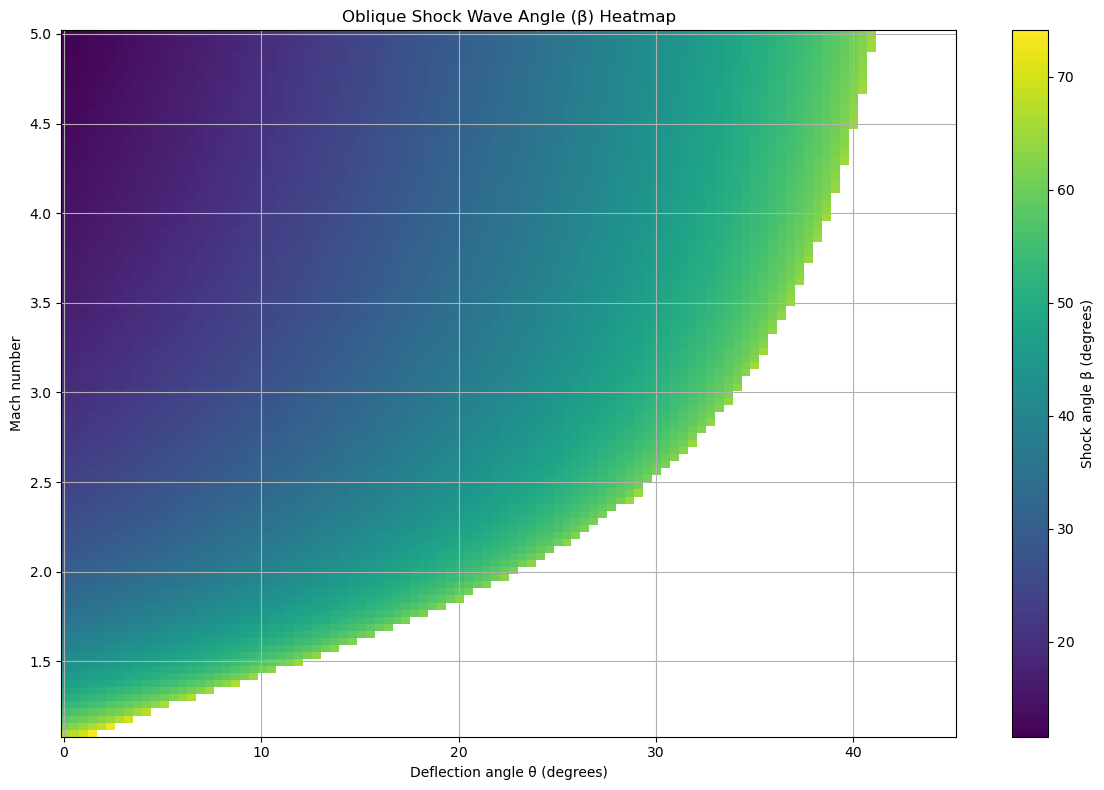

In [ ]:
# Create meshgrid for theta and Mach values
theta_dense = np.linspace(0.1, 45.0, 100)
mach_dense = np.linspace(1.1, 5.0, 100)
theta_mesh, mach_mesh = np.meshgrid(theta_dense, mach_dense)

# Initialize array to store beta values
beta_heatmap = np.zeros_like(theta_mesh)

# Calculate beta values for each point
for i in range(len(mach_dense)):
	for j in range(len(theta_dense)):
		betas = beta_solutions(theta_dense[j], mach_dense[i])
		if len(betas) > 0:
			# Use weak shock solution (first beta)
			beta_heatmap[i,j] = math.degrees(betas[0])
		else:
			beta_heatmap[i,j] = np.nan

# Create heatmap
plt.figure(figsize=(12, 8))
plt.pcolormesh(theta_mesh, mach_mesh, beta_heatmap, shading='auto', cmap='viridis')
plt.colorbar(label='Shock angle β (degrees)')
plt.xlabel('Deflection angle θ (degrees)')
plt.ylabel('Mach number')
plt.title('Oblique Shock Wave Angle (β) Heatmap')
plt.grid(True)
plt.tight_layout()
plt.show()

## Result computation

In [ ]:
theta_vals  = np.linspace(0.1, 45.0, 100)
mach_list = np.linspace(1.1, 5.0, 100)

weak_beta   = np.full((mach_list.size, theta_vals.size), np.nan)
strong_beta = np.full_like(weak_beta, np.nan)

for i, M in enumerate(mach_list):
    for j, theta in enumerate(theta_vals):
        betas = beta_solutions(theta, M)      # en rad
        if not betas:                         # θ > θ_max  ⇒ on sort de la boucle θ
            break
        weak_beta[i, j] = math.degrees(betas[0])
        if len(betas) > 1:                    # solution forte disponible
            strong_beta[i, j] = math.degrees(betas[1])


In [30]:
records = []
for i, M in enumerate(mach_list):
    for j, theta in enumerate(theta_vals):
        records.append(
            dict(M=M, theta=theta,
                 beta_weak=weak_beta[i, j],
                 beta_strong=strong_beta[i, j])
        )
df = pd.DataFrame.from_records(records)
df.head()

,M,theta,beta_weak,beta_strong
0,1.1,0.100000,65.731937,89.408167
1,1.1,0.174958,66.004380,88.963070
2,1.1,0.249917,66.284954,88.515537
3,1.1,0.324875,66.574409,88.064451
4,1.1,0.399833,66.873617,87.608610


## Visualisation

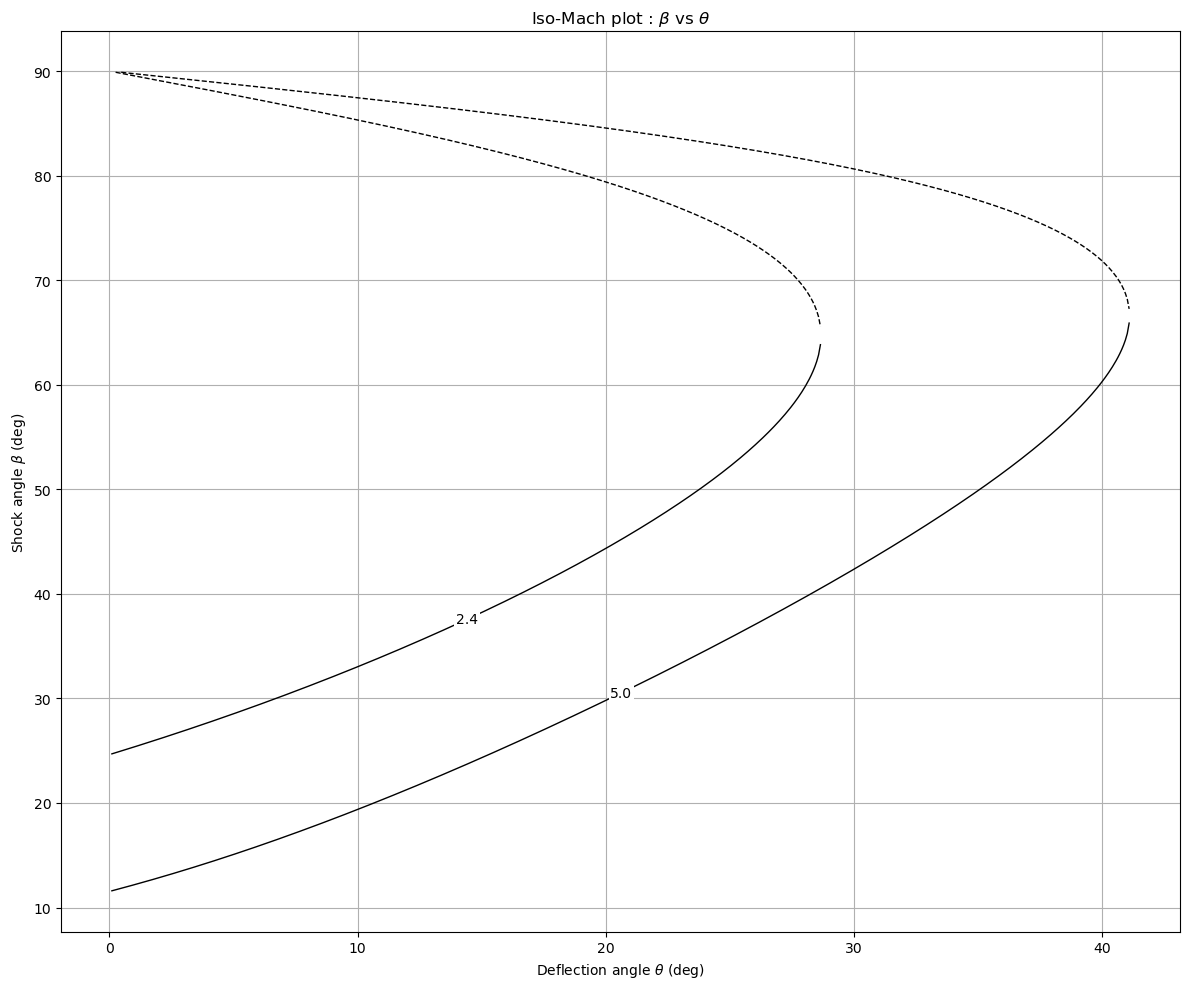

In [36]:
mach_dense  = np.round(np.arange(1.2, 3.0, 0.2), 1) # 1.2, 1.4, …, 2.8
mach_extra  = [3.0, 3.5, 4.0, 5.0]
iso_mach = np.concatenate((mach_dense, mach_extra))

plt.figure(figsize=(12, 10))

for M in iso_mach:
	# —— branche faible ——
	index = np.where(np.abs(mach_list - M) < 1e-10)[0]  # Using tolerance
	if len(index) > 0:
		i = index[0]
		valid = ~np.isnan(weak_beta[i])
		if valid.any():
			t = theta_vals[valid]
			b = weak_beta[i, valid]
			plt.plot(t, b, lw=1, color="black")
			mid = len(t)//2
			plt.text(t[mid], b[mid], f"{M}",
					 ha="center", va="center",
					 bbox=dict(fc="white", ec="none", pad=1.2))

		# —— branche forte ——
		valid = ~np.isnan(strong_beta[i])
		if valid.any():
			plt.plot(theta_vals[valid], strong_beta[i, valid],
					 lw=1, ls="--", color="black")

plt.xlabel(r"Deflection angle $\theta$ (deg)")
plt.ylabel(r"Shock angle $\beta$ (deg)")
plt.title(r"Iso-Mach plot : $\beta$ vs $\theta$")
plt.grid(True)
plt.tight_layout()
plt.show()


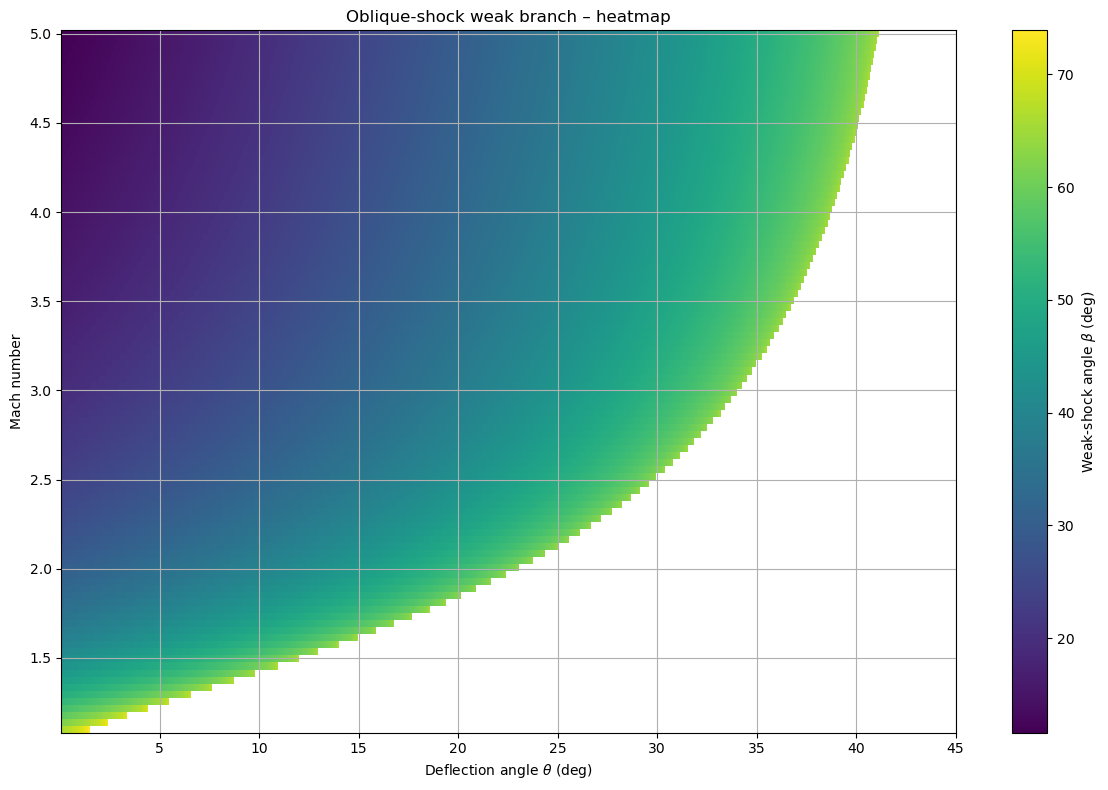

In [32]:
theta_mesh, mach_mesh = np.meshgrid(theta_vals, mach_list)

plt.figure(figsize=(12, 8))
plt.pcolormesh(theta_mesh, mach_mesh, weak_beta,      # déjà en degrés
               shading="auto", cmap="viridis")
plt.colorbar(label=r"Weak-shock angle $\beta$ (deg)")
plt.xlabel(r"Deflection angle $\theta$ (deg)")
plt.ylabel("Mach number")
plt.title("Oblique-shock weak branch – heatmap")
plt.grid(True); plt.tight_layout(); plt.show()
